In [43]:
# MLP with: 
### 1. Own implementation of a MLP class
### 2. numpy
### 3. Pytorch tensors
### 4. Pytorch CUDA tensor
### 5. Pytorch framework
### 6. Pytorch framework (CUDA)



Comparison on different implementations of a MLP, modified from: https://github.com/jcjohnson/pytorch-examples
A MLP 3 layers [784, 100, 10] is used as example, no bias elements added to the input layers

In [44]:
%matplotlib notebook
import numpy as np
import pickle, gzip
import mlp
import matplotlib.pyplot as plt
import torch
import time

## Parameters of MLP
 * __Number of layers__ : 3 (input, hidden1, output)
 * __Elements in layers__ : [784, 100, 10]   
 * __Activation function__ : Rectified Linear function
 * __Regularization parameter__ : 0
 * __Bias element added in input layers__ : False
  

In [45]:
# Useful functions
def initalize_weights_relu(size_layer, size_next_layer):
    #np.random.seed(5)
    # Method presented in "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classfication"
    # He et Al. 2015
    epsilon = np.sqrt(2.0 / (size_layer * size_next_layer) )
    # Weigts from Normal distribution mean = 0, std = epsion
    w = epsilon * (np.random.randn(size_next_layer, size_layer))
    return w.transpose()
def load_mnist():
    # Import MNIST data
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    # Training data, only
    X = valid_set[0]
    y = valid_set[1]

    # change y [1D] to Y [2D] sparse array coding class
    n_examples = len(y)
    labels = np.unique(y)
    Y = np.zeros((n_examples, len(labels)))
    for ix_label in range(len(labels)):
        # Find examples with with a Label = lables(ix_label)
        ix_tmp = np.where(y == labels[ix_label])[0]
        Y[ix_tmp, ix_label] = 1

    return X, Y, labels, y

## 1. Own implementation, class MLP

19.287599802017212 s


<IPython.core.display.Javascript object>


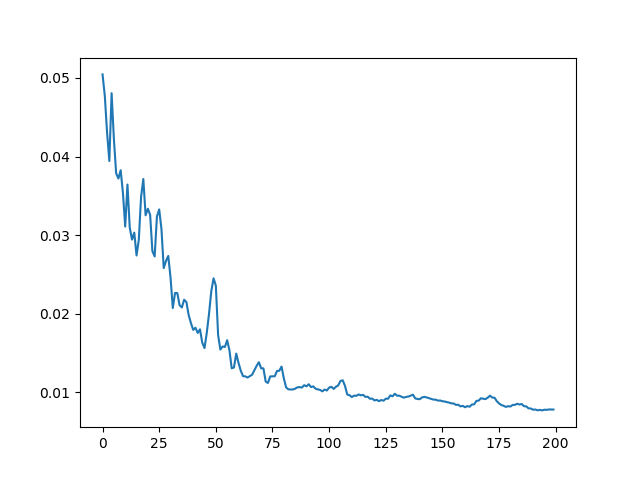

Training Accuracy: 93.49


In [46]:
# Load data
X, Y, labels, y  = load_mnist()

tic = time.time()

# Creating the MLP object initialize the weights
mlp_classifier = mlp.Mlp(size_layers = [784, 100, 10], 
                         act_funct   = 'relu',
                         reg_lambda  = 0,
                         bias_flag   = False)

# Training with Backpropagation and 400 iterations
iterations = 200
loss = np.zeros([iterations,1])

for ix in range(iterations):
    mlp_classifier.train(X, Y, 1)
    Y_hat = mlp_classifier.predict(X)
    # loss
    loss[ix] = (0.5)*np.square(Y_hat - Y).mean()

print(str(time.time() - tic) + ' s')
        
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
Y_hat = mlp_classifier.predict(X)
y_tmp = np.argmax(Y_hat, axis=1)
y_hat = labels[y_tmp]

acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## 2. numpy implementation
In this case Backpropagation is hard coded for 3 layers

11.255920886993408 s


<IPython.core.display.Javascript object>


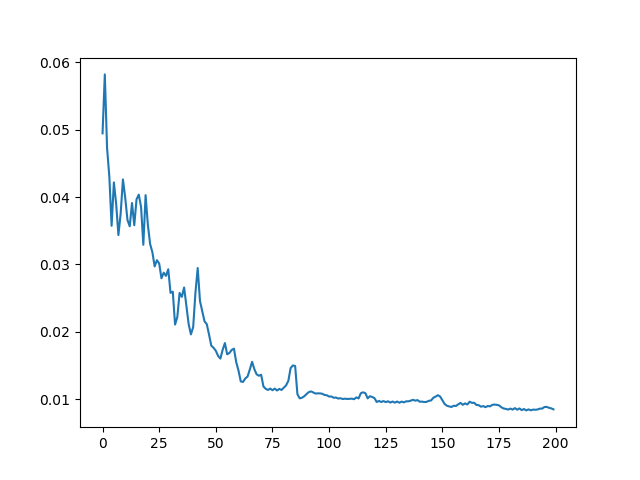

Training Accuracy: 93.49


In [47]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = initalize_weights_relu(784, 100)
w2 = initalize_weights_relu(100, 10)

iterations = 200
loss = np.zeros([iterations,1])

for ix in range(iterations):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.dot(w1)
    a2 = np.maximum(z2, 0)
    z3 = a2.dot(w2)
    a3 = np.maximum(z3, 0)
    Y_hat = a3
    
    # Compute loss
    loss[ix] = (0.5) * np.square(Y_hat - Y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.T.dot(d3) / n_examples
    d2_tmp = d3.dot(w2.T)
    d2 = d2_tmp.copy()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.T.dot(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))
    

## 3. Pytorch tensors

4.773953199386597 s


<IPython.core.display.Javascript object>


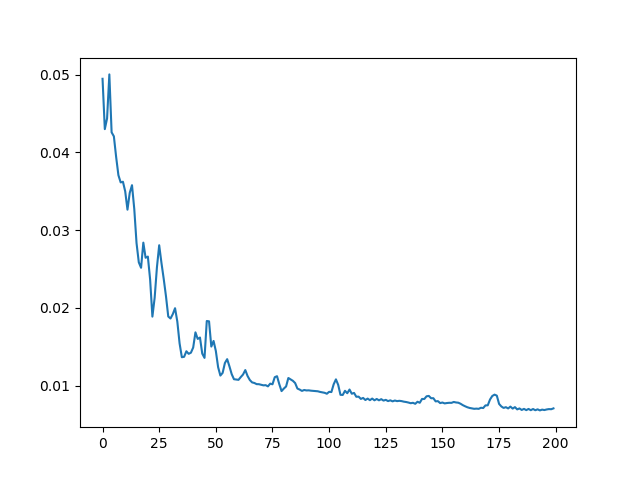

Training Accuracy: 93.49


In [48]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor

# Convert numpy arrays to Pytorch Tensors
X = torch.from_numpy(X).type(dtype)
Y = torch.from_numpy(Y).type(dtype)

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype)
w2 = torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype)

iterations = 200
loss = np.zeros([iterations,1])

for ix in range(iterations):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.mm(w1)
    a2 = z2.clamp(min=0)
    z3 = a2.mm(w2)
    a3 = z3.clamp(min=0)
    Y_hat = a3
    
    # Compute loss
    loss[ix] = (0.5) * np.square(Y_hat - Y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.t().mm(d3) / n_examples
    d2_tmp = d3.mm(w2.t())
    d2 = d2_tmp.clone()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.t().mm(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## 4. Pytorch CUDA tensors

0.4136044979095459 s


<IPython.core.display.Javascript object>


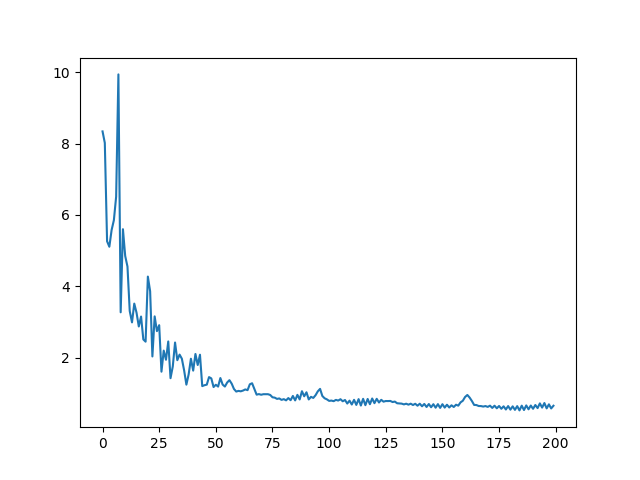

Training Accuracy: 92.89


In [49]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.cuda.FloatTensor

# Convert numpy arrays to Pytorch Tensors
X = torch.from_numpy(X).type(dtype)
Y = torch.from_numpy(Y).type(dtype)

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype)
w2 = torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype)

iterations = 200
loss = np.zeros([iterations,1])

for ix in range(iterations):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.mm(w1)
    a2 = z2.clamp(min=0)
    z3 = a2.mm(w2)
    a3 = z3.clamp(min=0)
    Y_hat = a3
        
    y_tmp = torch.max(Y_hat, dim=1)[1]
    y_tmp = y_tmp.cpu()
    y_hat = labels[y_tmp.numpy()]
    
    # Compute loss
    loss[ix] = (0.5) * np.square(y_hat - y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.t().mm(d3) / n_examples
    d2_tmp = d3.mm(w2.t())
    d2 = d2_tmp.clone()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.t().mm(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## Pytorch variables and automatic differentiation (autograd)

6.85544490814209 s


<IPython.core.display.Javascript object>


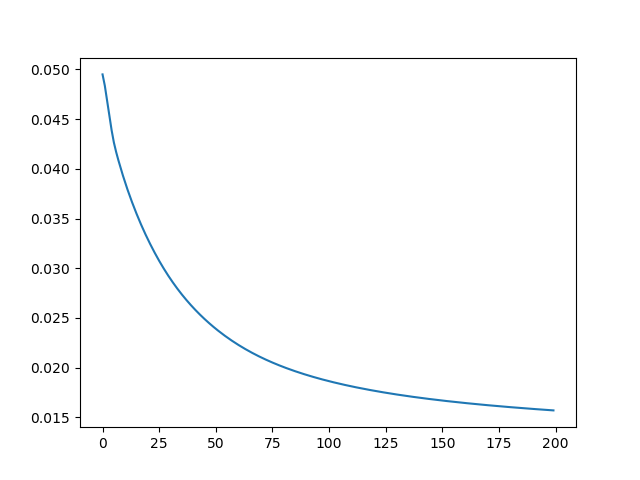

Training Accuracy: 80.37


In [50]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor

# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

# size_layers = [784, 100, 10]

# Randomly initialize weights
# These tensors are wrapped in Variables to produce gradients, however we NEED the gradients to this variables
w1 = Variable(torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype), requires_grad = True)
w2 = Variable(torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype), requires_grad = True)

iterations = 200
loss = np.zeros([iterations,1])

for ix in range(iterations):
    n_examples = X.data.shape[0]
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = X.mm(w1).clamp(min=0).mm(w2).clamp(min=0)
    #       MatMul   ReLu         MatMul Relu
           
    # Compute loss
    loss_var = (0.5) * (Y_hat - Y).pow(2).mean()
    loss[ix] = loss_var.data[0]
    
    # Backward pass
    loss_var.backward()
    
    # Gradients
    grad1 = w1.grad.data
    grad2 = w2.grad.data
    
    # Update weights
    w1.data = w1.data - grad1 
    w2.data = w2.data - grad2
    
    # Reset gradients
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## Pytorch `nn` package

7.76997709274292 s


<IPython.core.display.Javascript object>


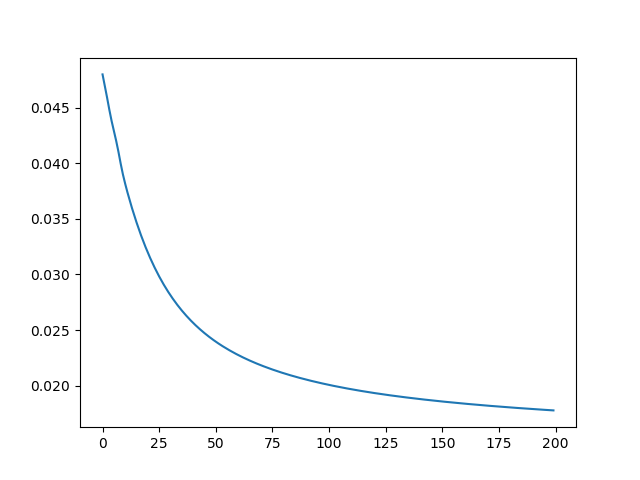

Training Accuracy: 74.4


In [51]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor


# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

model = torch.nn.Sequential(
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU(),
        )

loss_fn = torch.nn.MSELoss()

for ix in range(iterations):
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = model(X)
    
    # Compute loss
    loss_var = 0.5 * loss_fn(Y_hat, Y)
    loss[ix] = loss_var.data[0]
    
    # Reset gradients
    model.zero_grad()
    
    # Backward pass
    loss_var.backward()
    
    # Update weights
    for param in model.parameters():
        param.data = param.data - param.grad.data
    
print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## Pytorch `nn` package (in GPU)

0.5113604068756104 s


<IPython.core.display.Javascript object>


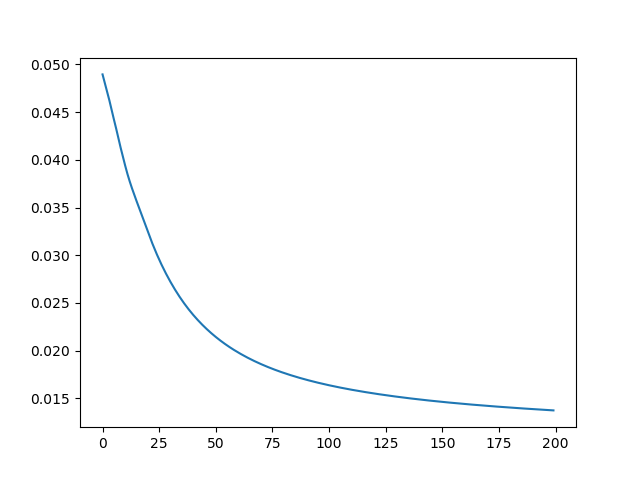

Training Accuracy: 83.45


In [52]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.cuda.FloatTensor


# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

model = torch.nn.Sequential(
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU(),
        )

model.cuda(0)

loss_fn = torch.nn.MSELoss()

for ix in range(iterations):
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = model(X)
    
    # Compute loss
    loss_var = 0.5 * loss_fn(Y_hat, Y)
    loss[ix] = loss_var.data[0]
    
    # Reset gradients
    model.zero_grad()
    
    # Backward pass
    loss_var.backward()
    
    # Update weights
    for param in model.parameters():
        param.data = param.data - param.grad.data
    
print(str(time.time() - tic) + ' s')
    
# Ploting loss vs iterations
plt.figure()
ix = np.arange(iterations)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.cpu().numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))